# Loudoun County Growth Study

## Import Libraries

In [1]:
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

## Cell 2: Define Column Renaming Mapping

In [2]:
# Column Renaming Map
column_renaming_map = {
    # Demographics Data
    'geographic_area_name_(name)': 'geo_name',
    '2017_naics_code_(naics2017)': 'naics_code',
    'meaning_of_naics_code_(naics2017_label)': 'naics_desc',
    'meaning_of_legal_form_of_organization_code_(lfo_label)': 'legal_form',
    'meaning_of_employment_size_of_establishments_code_(empszes_label)': 'emp_size',
    'year_(year)': 'year',
    'number_of_establishments_(estab)': 'num_estabs',
    'annual_payroll_($1,000)_(payann)': 'ann_payroll_thousands',
    'first_quarter_payroll_($1,000)_(payqtr1)': 'q1_payroll_thousands',
    'number_of_employees_(emp)': 'num_emps',
    'county': 'county',  # Keep as is

    # Decennial Population Data
    'label_(grouping)': 'label',
    'loudoun_county,_virginia!!count': 'loudoun_va_count',
    'loudoun_county,_virginia!!percent': 'loudoun_va_pct',
    'data_type': 'data_type',

    # GDP Data
    'geofips': 'geo_fips',
    'geoname': 'geo_name',
    'linecode': 'line_code',
    'description': 'description',
    # Years can remain as is
    'county': 'county',

    # BLS Data
    'area_fips': 'area_fips',
    'own_code': 'own_code',
    'industry_code': 'ind_code',
    'agglvl_code': 'agg_level_code',
    'size_code': 'size_code',
    'year': 'year',
    'qtr': 'quarter',
    'disclosure_code': 'disc_code',
    'annual_avg_estabs': 'ann_avg_estabs',
    'annual_avg_emplvl': 'ann_avg_emp_lvl',
    # Continue for other columns as needed
    'quarter': 'quarter',
}


## Cell 3: Define simplify_column_name Function

In [3]:
def simplify_column_name(col_name):
    """
    Simplifies a column name by removing unnecessary words and abbreviating common terms,
    without using the 're' module.
    """
    # Remove content within parentheses
    while '(' in col_name and ')' in col_name:
        start = col_name.find('(')
        end = col_name.find(')', start)
        if end != -1:
            col_name = col_name[:start] + col_name[end+1:]
        else:
            break  # No closing parenthesis found

    # Replace '!!' with '_'
    col_name = col_name.replace('!!', '_')

    # Remove special characters and replace them with underscores
    special_chars = ' !@#$%^&*()+={}[]|\\:;"\'<>,.?/~`-'
    for char in special_chars:
        col_name = col_name.replace(char, '_')

    # Replace multiple underscores with a single underscore
    while '__' in col_name:
        col_name = col_name.replace('__', '_')

    # Convert to lowercase
    col_name = col_name.lower()

    # Abbreviate common terms
    abbreviations = {
        'geographic_area_name': 'geo_name',
        'number_of_establishments': 'num_estabs',
        'annual_payroll': 'ann_payroll',
        'first_quarter_payroll': 'q1_payroll',
        'meaning_of': '',
        'naics_code': 'naics_code',
        'employment_size_of_establishments_code': 'emp_size',
        'legal_form_of_organization_code': 'legal_form',
        'number_of_employees': 'num_emps',
        'label_grouping': 'label',
        'percent': 'pct',
        'estimate': 'est',
        'margin_of_error': 'moe',
        'total': '',
        'male': 'male',
        'female': 'female',
        'county': 'cty',
        'virginia': 'va',
        'california': 'ca',
        'maryland': 'md',
        'north_carolina': 'nc',
        'tennessee': 'tn',
        'texas': 'tx',
        'description': 'desc',
        'ownership_code': 'own_code',
        'industry_code': 'ind_code',
        'size_code': 'size_code',
        'quarter': 'qtr',
        'disclosure_code': 'disc_code',
        'annual_avg_estabs': 'ann_avg_estabs',
        'annual_avg_emplvl': 'ann_avg_emp_lvl',
        # Add other abbreviations as needed
    }

    for long, short in abbreviations.items():
        col_name = col_name.replace(long, short)

    # Remove leading and trailing underscores
    col_name = col_name.strip('_')

    return col_name


## Cell 4: Update clean_dataframe Function


In [4]:
def clean_dataframe(df):
    """
    Cleans a DataFrame:
    - Removes columns and rows with only NaNs or nulls
    - Handles NaNs and null values
    - Standardizes and simplifies column names
    - Removes duplicate rows and columns
    """
    df = df.copy()

    # Remove columns with all NaNs or nulls
    df.dropna(axis=1, how='all', inplace=True)

    # Remove rows with all NaNs or nulls
    df.dropna(axis=0, how='all', inplace=True)

    # Reset index to ensure it's unique
    df.reset_index(drop=True, inplace=True)

    # Fill missing data forward and backward
    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)

    # Standardize column names
    df.columns = df.columns.str.strip().str.lower()

    # Simplify column names
    df.columns = [simplify_column_name(col) for col in df.columns]

    # Remove duplicate columns
    df = df.loc[:, ~df.columns.duplicated()]

    # Remove duplicate rows
    df.drop_duplicates(inplace=True)

    return df



## Cell 5: Define merge_files Function

In [5]:
def merge_files(file_info_list, output_file, add_columns=None, file_type='general'):
    """
    Merges multiple CSV files into a single DataFrame and saves it.
    - file_info_list: List of dictionaries containing 'file_path' and optional additional info.
    - output_file: Path to save the merged CSV.
    - add_columns: Dictionary with column names as keys and values or functions as values.
    - file_type: Type of files being merged ('general', 'bls', 'census', etc.).
    """
    merged_data = pd.DataFrame()
    for info in file_info_list:
        try:
            file_path = info['file_path']
            df = pd.read_csv(file_path)
            df = clean_dataframe(df)

            # Add additional columns
            if add_columns:
                for col_name, value in add_columns.items():
                    if callable(value):
                        df[col_name] = value(info)
                    else:
                        df[col_name] = value

            # Additional processing based on file type
            if file_type == 'bls':
                df['year'] = info.get('year', df.get('year', None))
                if 'quarter' in info and info['quarter']:
                    df['quarter'] = info['quarter']

            elif file_type == 'census':
                df['year'] = info.get('year', df.get('year', None))
                df['data_type'] = info.get('data_type', df.get('data_type', None))

            # Concatenate
            merged_data = pd.concat([merged_data, df], ignore_index=True)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Save the merged data
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    merged_data.to_csv(output_file, index=False)
    print(f"Merged data saved to {output_file}")
    return merged_data



## Define File Paths

In [6]:
# Define File Paths for Demographic Data
demographic_files = {
    "Dallas TX": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Demographics\Dallas_County_Texas_CBP.csv",
    "Davidson TN": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Demographics\Davidson_County_Tennessee_CBP.csv",
    "Fairfax VA": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Demographics\Fairfax_County_Virginia_CBP.csv",
    "Loudoun VA": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Demographics\Loudoun_County_Virginia_CBP.csv",
    "Montgomery MD": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Demographics\Montgomery_County_Maryland_CBP.csv",
    "Santa Clara CA": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Demographics\Santa_Clara_County_California_CBP.csv",
    "Wake NC": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Demographics\Wake_County_North_Carolina_CBP.csv",
}



In [7]:
# Convert demographic_files dictionary into a list of dictionaries
file_info_list = [{"file_path": path, "county": county} for county, path in demographic_files.items()]

# Merge and Save Demographics Data
demographics_output_file = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Merged Files\merged_demographics_data.csv"

merged_demographics_data = merge_files(
    file_info_list,
    demographics_output_file,
    add_columns={"county": lambda info: info["county"]}
)


Merged data saved to C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Merged Files\merged_demographics_data.csv


## Cell 7: Process Decennial Population Data

In [8]:
# File path and output location for Decennial Population
decennial_file_info = [
    {"file_path": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Demographics\2020_decennial_population_housing.csv",
     "data_type": "Decennial Population"}
]

decennial_output_file = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Merged Files\merged_decennial_population_data.csv"

# Process and merge the Decennial Population data
merged_decennial_data = merge_files(
    decennial_file_info,
    decennial_output_file,
    add_columns={"data_type": lambda info: info['data_type']}
)


Merged data saved to C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Merged Files\merged_decennial_population_data.csv


## Merge GDP Data


In [9]:
# Define File Paths for GDP Data
gdp_files = [
    {"key": "Loudoun County", "file_path": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\GDP\Loudoun_GDP_summary.csv"},
    {"key": "Fairfax County", "file_path": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\GDP\Fairfax_GDP_summary.csv"},
    {"key": "Santa Clara County", "file_path": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\GDP\Santa_Clara_CA_GDP_summary.csv"},
    {"key": "Montgomery County", "file_path": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\GDP\Mountgomery_MD_GDP_summary.csv"},
    {"key": "Wake County", "file_path": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\GDP\Wake_NC_GDP_summary.csv"},
    {"key": "Davidson County", "file_path": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\GDP\Davidson_TN_GDP_summary.csv"},
    {"key": "Dallas County", "file_path": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\GDP\Dallas_TX_GDP_summary.csv"},
]

# Merge GDP Data
gdp_output_file = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Merged Files\merged_gdp_data.csv"

merged_gdp_data = merge_files(
    gdp_files,
    gdp_output_file,
    add_columns={"county": lambda info: info['key']}
)


Merged data saved to C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Merged Files\merged_gdp_data.csv


In [10]:
# Define File Paths for BLS Data
bls_files = {
    "Dallas": [
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Dallas\BLS_Dallas_2020.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Dallas\BLS_Dallas_2021.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Dallas\BLS_Dallas_2022.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Dallas\BLS_Dallas_2023.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Dallas\BLS_Dallas_2024_q1.csv",
    ],
    "Davidson": [
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Davidson\BLS_Davidson_2020.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Davidson\BLS_Davidson_2021.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Davidson\BLS_Davidson_2022.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Davidson\BLS_Davidson_2023.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Davidson\BLS_Davidson_2024_q1.csv",
    ],
    "Fairfax": [
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Fairfax\BLS_Fairfax_2020.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Fairfax\BLS_Fairfax_2021.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Fairfax\BLS_Fairfax_2022.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Fairfax\BLS_Fairfax_2023.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Fairfax\BLS_Fairfax_2024_q1.csv",
    ],
    "Loudoun": [ 
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Loudoun\BLS_Loudoun_2020.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Loudoun\BLS_Loudoun_2021.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Loudoun\BLS_Loudoun_2022.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Loudoun\BLS_Loudoun_2023.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Loudoun\BLS_Loudoun_2024_q1.csv",
    ],
    "Montgomery": [   
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Montgomery\BLS_Montgomery_2020.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Montgomery\BLS_Montgomery_2021.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Montgomery\BLS_Montgomery_2022.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Montgomery\BLS_Montgomery_2023.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Montgomery\BLS_Montgomery_2024_q1.csv",
    ],
    "Santa Clara": [
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Santa Clara\BLS_Santa_Clara_2020.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Santa Clara\BLS_Santa_Clara_2021.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Santa Clara\BLS_Santa_Clara_2022.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Santa Clara\BLS_Santa_Clara_2023.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Santa Clara\BLS_Santa_Clara_2024_q1.csv",
    ],
    "Wake": [  
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Wake\BLS_Wake_2020.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Wake\BLS_Wake_2021.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Wake\BLS_Wake_2022.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Wake\BLS_Wake_2023.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Bureau of Labor Statistics\Wake\BLS_Wake_2024_q1.csv",
    ],
}


In [11]:
# Create a list to hold dictionaries with file info
bls_file_info = []

for county, file_list in bls_files.items():
    for file_path in file_list:
        # Extract the file name from the file path
        file_name = os.path.basename(file_path)
        # Remove the extension
        base_name = os.path.splitext(file_name)[0]
        # Split by underscores
        parts = base_name.split('_')
        # The last part might be '2020', '2024', or '2024_q1'
        year_part = parts[-1]

        # Check if there's a quarter indicated
        if 'q' in year_part.lower():
            # Split the year and quarter
            year = year_part[:4]
            quarter_part = year_part.lower().split('q')[1]
            quarter = 'Q' + quarter_part  # Format quarter as 'Q1', 'Q2', etc.
        else:
            year = year_part
            quarter = None  # No quarter information

        # Append the information to the list
        bls_file_info.append({
            'file_path': file_path,
            'county': county,
            'year': year,
            'quarter': quarter
        })

# Merge BLS Data
bls_output_file = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Merged Files\merged_bls_data.csv"

merged_bls_data = merge_files(
    bls_file_info,
    bls_output_file,
    add_columns={
        'county': lambda info: info['county'],
        'year': lambda info: info['year'],
        'quarter': lambda info: info.get('quarter', None)
    },
    file_type='bls'
)


Merged data saved to C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Merged Files\merged_bls_data.csv


## Cell 10: Merge Census Data


In [12]:
# Define File Paths for Census Data
census_files = {
    "2010": [
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2010\2010_household_income_transformed.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2010\2010_housing_characteristics_transformed.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2010\2010_housing_occupancy_transformed.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2010\2010_population_age_sex_transformed.csv",
    ],
    "2015": [
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2015\2015_transformed_household_income_final_safe.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2015\2015_transformed_housing_characteristics_final_safe.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2015\2015_transformed_housing_occupancy_final_safe.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2015\2015_transformed_population_age_sex_final_safe.csv",
    ],
    "2020": [
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2020\transformed_2020_household_income.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2020\transformed_2020_housing_characteristics.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2020\transformed_2020_housing_occupancy.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2020\transformed_2020_population_age_sex.csv",
    ],
    "2023": [
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2023\Household_Income_2023.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2023\Housing_Characteristics_2023.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2023\Housing_Occupancy_2023.csv",
        r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\US Census\2023\Population_Age_Sex_2023.csv",
    ],
}

# Create a list to hold dictionaries with file info
census_file_info = []

for year, file_list in census_files.items():
    for file_path in file_list:
        # Extract the file name from the file path
        file_name = os.path.basename(file_path)
        # Remove the extension
        base_name = os.path.splitext(file_name)[0]
        # Extract data type from the file name
        data_type = '_'.join(base_name.split('_')[1:])

        # Read and flip (transpose) each individual file
        df = pd.read_csv(file_path)
        flipped_df = df.transpose()

        # Save flipped data to a temporary file for merging
        flipped_file_path = file_path.replace('.csv', '_flipped.csv')
        flipped_df.to_csv(flipped_file_path)

        census_file_info.append({
            'file_path': flipped_file_path,
            'year': year,
            'data_type': data_type
        })

# Merge the flipped Census Data
census_output_file = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Merged Files\merged_census_data.csv"
merged_census_data = merge_files(census_file_info, census_output_file, file_type='census')

# Save the merged data to a new file
merged_output_file = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Merged Files\merged_census_data.csv"
merged_census_data.to_csv(merged_output_file)




Merged data saved to C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Merged Files\merged_census_data.csv


## Cell 11: Display Merged DataFrames


In [13]:
# Display the first few rows of merged dataframes
print("Demographics Data:")
display(merged_demographics_data.head())

print("Decennial Population Data:")
display(merged_decennial_data.head())

print("GDP Data:")
display(merged_gdp_data.head())

print("BLS Data:")
display(merged_bls_data.head())

print("Census Data:")
display(merged_census_data.head())


Demographics Data:


,geo_name,2017_naics_code,naics_code,legal_form,emp_size,year,num_estabs,ann_payroll,q1_payroll,num_emps,county
0,"Dallas County, Texas",00,Total for all sectors,All establishments,All establishments,2019,"67,311","99,304,828","26,327,259","1,534,430",Dallas TX
1,"Dallas County, Texas",00,Total for all sectors,All establishments,Establishments with less than 5 employees,2019,"34,339",N,N,N,Dallas TX
2,"Dallas County, Texas",00,Total for all sectors,All establishments,Establishments with 5 to 9 employees,2019,"11,381",N,N,N,Dallas TX
3,"Dallas County, Texas",00,Total for all sectors,All establishments,Establishments with 10 to 19 employees,2019,"8,771",N,N,N,Dallas TX
4,"Dallas County, Texas",00,Total for all sectors,All establishments,Establishments with 20 to 49 employees,2019,"7,321",N,N,N,Dallas TX


Decennial Population Data:


,label,loudoun_cty_va_count,loudoun_cty_va_pct,data_type
0,SEX AND AGE,"420,959",100.0%,Decennial Population
1,Total population,"420,959",100.0%,Decennial Population
2,Under 5 years,"27,065",6.4%,Decennial Population
3,5 to 9 years,"33,089",7.9%,Decennial Population
4,10 to 14 years,"36,363",8.6%,Decennial Population


GDP Data:


,geofips,geoname,linecode,desc,2001,2002,2003,2004,2005,2006,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,county
0,51107,"Loudoun, VA",1.0,Real GDP (thousands of chained 2017 dollars),1.178164e+07,1.233191e+07,1.261795e+07,1.437287e+07,1.487458e+07,1.685159e+07,...,2.284566e+07,2.398940e+07,2.520669e+07,26813789.0,2.828036e+07,2.957344e+07,2.872476e+07,3.176395e+07,3.377183e+07,Loudoun County
1,51107,"Loudoun, VA",2.0,Chain-type quantity indexes for real GDP,4.393900e+01,4.599100e+01,4.705800e+01,5.360300e+01,5.547400e+01,6.284700e+01,...,8.520100e+01,8.946700e+01,9.400600e+01,100.0,1.054690e+02,1.102920e+02,1.071270e+02,1.184610e+02,1.259500e+02,Loudoun County
2,51107,"Loudoun, VA",3.0,Current-dollar GDP (thousands of current dollars),9.719971e+06,1.034350e+07,1.066994e+07,1.229215e+07,1.294812e+07,1.501156e+07,...,2.215907e+07,2.366539e+07,2.513558e+07,26813789.0,2.852645e+07,3.041010e+07,2.989243e+07,3.361426e+07,3.755871e+07,Loudoun County
3,51919,"Fairfax, Fairfax City + Falls Church, VA*",1.0,Real GDP (thousands of chained 2017 dollars),7.485829e+07,7.740763e+07,8.180330e+07,8.735250e+07,9.330231e+07,9.503624e+07,...,1.085331e+08,1.099238e+08,1.114445e+08,114188029.0,1.192737e+08,1.256096e+08,1.253454e+08,1.333528e+08,1.379258e+08,Fairfax County
4,51919,"Fairfax, Fairfax City + Falls Church, VA*",2.0,Chain-type quantity indexes for real GDP,6.555700e+01,6.779000e+01,7.163900e+01,7.649900e+01,8.170900e+01,8.322800e+01,...,9.504800e+01,9.626600e+01,9.759700e+01,100.0,1.044540e+02,1.100020e+02,1.097710e+02,1.167840e+02,1.207880e+02,Fairfax County


BLS Data:


,area_fips,own_code,ind_code,agglvl_code,size_code,year,qtr,disc_code,ann_avg_estabs,ann_avg_emp_lvl,...,oty_month3_emplvl_chg,oty_month3_emplvl_pct_chg,oty__qtrly_wages_chg,oty__qtrly_wages_pct_chg,oty_taxable_qtrly_wages_chg,oty_taxable_qtrly_wages_pct_chg,oty_qtrly_contributions_chg,oty_qtrly_contributions_pct_chg,oty_avg_wkly_wage_chg,oty_avg_wkly_wage_pct_chg
0,48113,0,10,70,0,2020,A,N,81171.0,1667356.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48113,1,10,71,0,2020,A,N,167.0,26129.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48113,1,101,72,0,2020,A,N,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48113,1,1013,73,0,2020,A,N,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48113,1,102,72,0,2020,A,N,166.0,26123.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Census Data:


,unnamed_0,0,1,2,3,4,5,6,7,8,...,4470,4471,4472,4473,4474,4475,4476,4477,4478,4479
0,Label (Grouping),Total,"Less than $10,000","$10,000 to $14,999","$15,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Santa Clara County, California!!Households!!Es...","599,235",4.5%,3.1%,7.0%,6.1%,10.2%,13.7%,12.0%,19.1%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,income_range,"Santa Clara County, California!!Households!!Ma...","Santa Clara County, California!!Households!!Ma...","Santa Clara County, California!!Households!!Ma...","Santa Clara County, California!!Households!!Ma...","Santa Clara County, California!!Households!!Ma...","Santa Clara County, California!!Households!!Ma...","Santa Clara County, California!!Households!!Ma...","Santa Clara County, California!!Households!!Ma...","Santa Clara County, California!!Households!!Ma...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,count,"±3,770",±0.5,±0.4,±0.5,±0.5,±0.7,±0.7,±0.7,±0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Label (Grouping),HOUSING OCCUPANCY,Total housing units,Occupied housing units,Vacant housing units,Homeowner vacancy rate,Rental vacancy rate,UNITS IN STRUCTURE,Total housing units,"1-unit, detached",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 2: Extract and Analyze Data


# A. Number of Businesses



           county  total_businesses
0       Dallas TX            822176
1     Davidson TN            247397
2      Fairfax VA            380860
3      Loudoun VA            136270
4   Montgomery MD            329818
5  Santa Clara CA            587474
6         Wake NC            372552


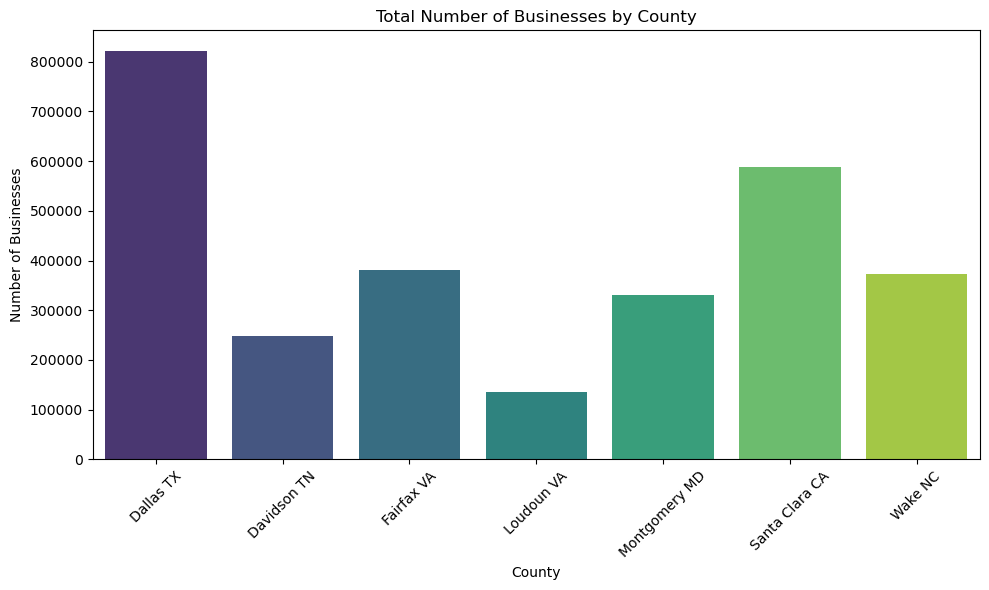

In [14]:
# Load the demographics data
demographics_file = demographics_output_file
demographics_df = pd.read_csv(demographics_file)

# Ensure 'num_estabs' is numeric
demographics_df['num_estabs'] = pd.to_numeric(demographics_df['num_estabs'].replace(',', '', regex=True), errors='coerce')

# Group by county and sum the number of establishments
num_businesses = demographics_df.groupby('county')['num_estabs'].sum().reset_index()
num_businesses.rename(columns={'num_estabs': 'total_businesses'}, inplace=True)

# Display
print(num_businesses)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=num_businesses, x='county', y='total_businesses', palette='viridis')
plt.title('Total Number of Businesses by County')
plt.xlabel('County')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# B. Employment Figures


        county  total_employment
0       Dallas        15989994.0
1     Davidson         4877326.0
2      Fairfax          194420.0
3      Loudoun         1641987.0
4   Montgomery         2509149.0
5  Santa Clara         9775692.0
6         Wake         5699358.0


C:\Users\AKKem\AppData\Local\Temp\ipykernel_8740\3321011326.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bls_latest_year['ann_avg_emp_lvl'] = pd.to_numeric(bls_latest_year['ann_avg_emp_lvl'], errors='coerce')


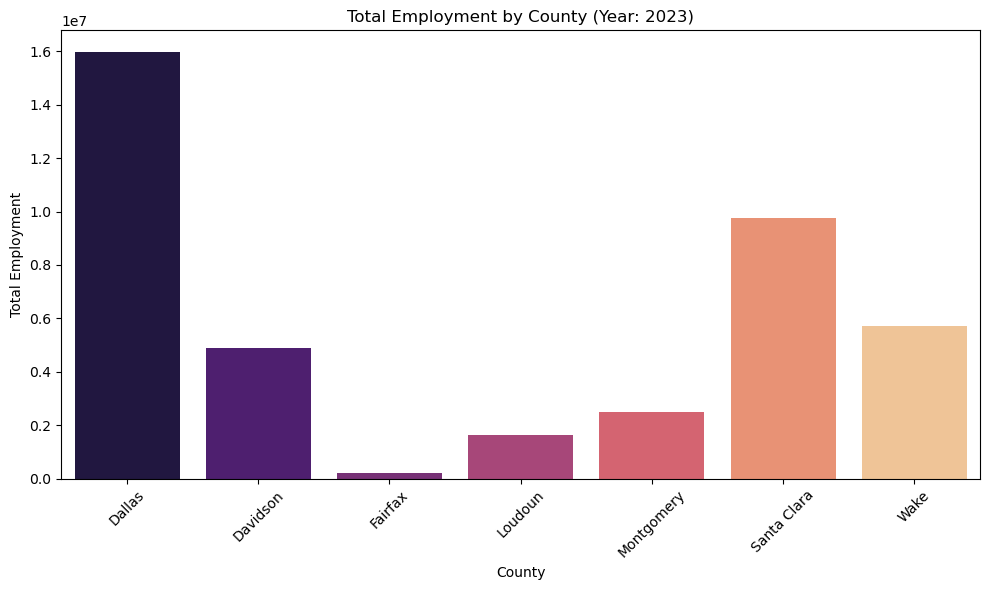

In [15]:
# Load the BLS data
bls_df = merged_bls_data.copy()

# Ensure 'year' is numeric and get the latest year
bls_df['year'] = pd.to_numeric(bls_df['year'], errors='coerce')
latest_year = bls_df['year'].max()

# Filter for the latest year
bls_latest_year = bls_df[bls_df['year'] == latest_year]

# Ensure 'ann_avg_emp_lvl' is numeric
bls_latest_year['ann_avg_emp_lvl'] = pd.to_numeric(bls_latest_year['ann_avg_emp_lvl'], errors='coerce')

# Group by county and sum employment levels
employment_figures = bls_latest_year.groupby('county')['ann_avg_emp_lvl'].sum().reset_index()
employment_figures.rename(columns={'ann_avg_emp_lvl': 'total_employment'}, inplace=True)

# Display
print(employment_figures)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=employment_figures, x='county', y='total_employment', palette='magma')
plt.title(f'Total Employment by County (Year: {int(latest_year)})')
plt.xlabel('County')
plt.ylabel('Total Employment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 3. Cost of Labor by Industry

        county                                         naics_code  \
0    Dallas TX                    Accommodation and food services   
1    Dallas TX  Administrative and support and waste managemen...   
2    Dallas TX         Agriculture, forestry, fishing and hunting   
3    Dallas TX                Arts, entertainment, and recreation   
4    Dallas TX                                       Construction   
..         ...                                                ...   
141    Wake NC                                       Retail trade   
142    Wake NC                              Total for all sectors   
143    Wake NC                     Transportation and warehousing   
144    Wake NC                                          Utilities   
145    Wake NC                                    Wholesale trade   

     avg_payroll_per_employee  
0                   20.104506  
1                   39.535296  
2                   40.418605  
3                   32.483652  
4          

C:\Users\AKKem\AppData\Local\Temp\ipykernel_8740\1200269626.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


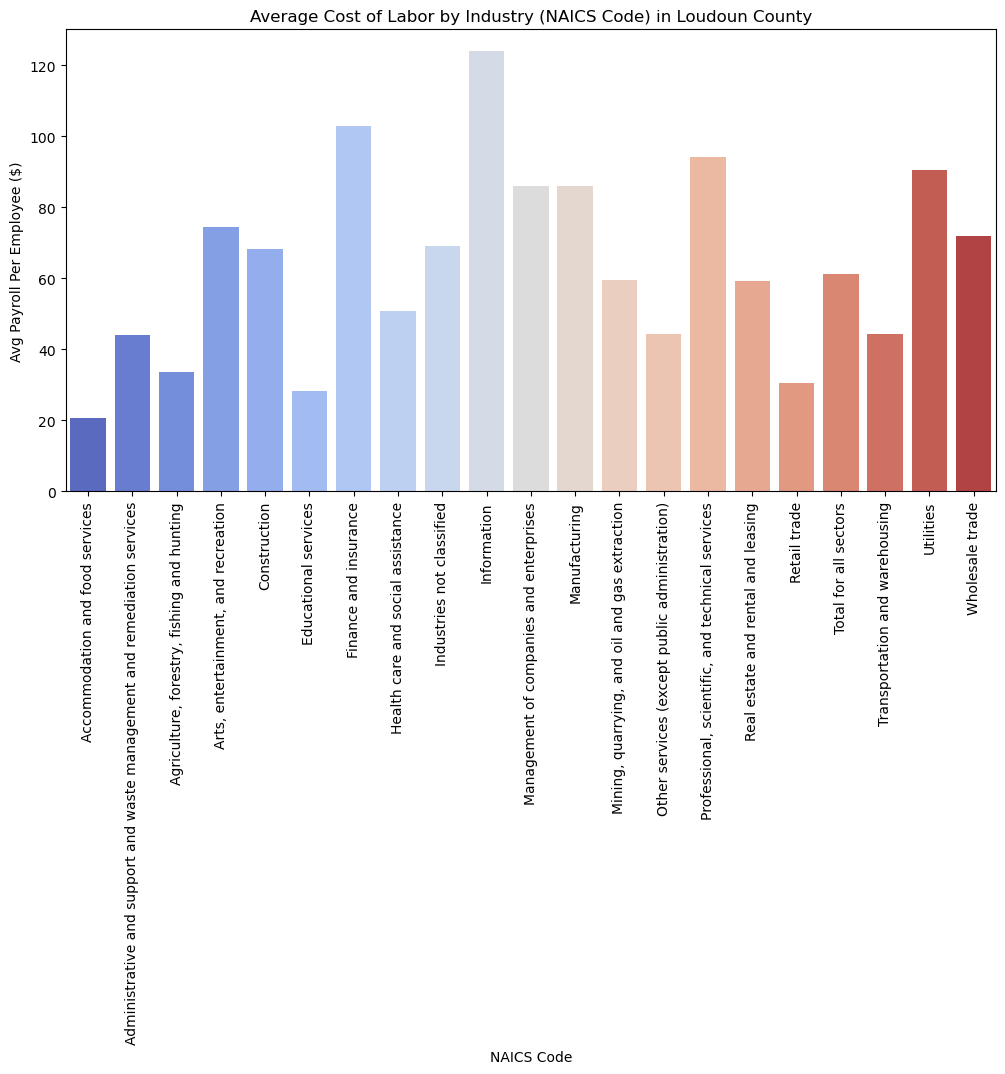

In [16]:
# Ensure the columns are numeric
demographics_df['ann_payroll'] = pd.to_numeric(
    demographics_df['ann_payroll'].replace(',', '', regex=True), errors='coerce'
)
demographics_df['num_emps'] = pd.to_numeric(
    demographics_df['num_emps'].replace(',', '', regex=True), errors='coerce'
)

# Drop rows where payroll or employees are missing or zero
demographics_df = demographics_df.dropna(subset=['ann_payroll', 'num_emps'])
demographics_df = demographics_df[(demographics_df['num_emps'] > 0) & (demographics_df['ann_payroll'] > 0)]

# Group by county and industry code, then calculate average payroll per employee
cost_of_labor = demographics_df.groupby(['county', 'naics_code']).apply(
    lambda x: x['ann_payroll'].sum() / x['num_emps'].sum()
).reset_index(name='avg_payroll_per_employee')

# Display results
print(cost_of_labor)

# Filter for Loudoun County and plot
loudoun_labor = cost_of_labor[cost_of_labor['county'] == 'Loudoun VA']
plt.figure(figsize=(12, 6))
sns.barplot(data=loudoun_labor, x='naics_code', y='avg_payroll_per_employee', palette='coolwarm')
plt.title('Average Cost of Labor by Industry (NAICS Code) in Loudoun County')
plt.xlabel('NAICS Code')
plt.ylabel('Avg Payroll Per Employee ($)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## 4. Economic Growth and Income Over Time

Columns after renaming: ['geo_fips', 'geo_name', 'line_code', 'desc', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', 'county']


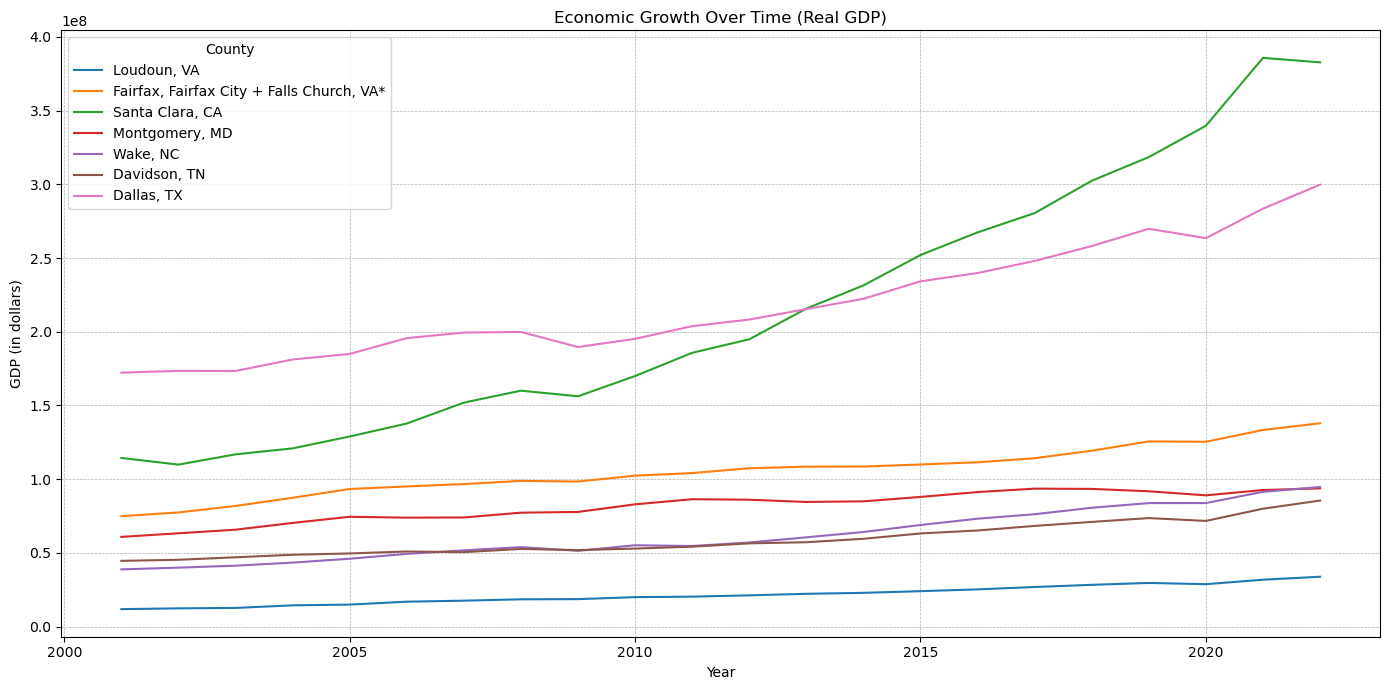

In [17]:
# Section 4: Economic Growth and Income Over Time

# Load GDP data
gdp_df = merged_gdp_data.copy()

# Apply column renaming map to gdp_df
gdp_df.rename(columns=column_renaming_map, inplace=True)

# Check the columns after renaming
print("Columns after renaming:", gdp_df.columns.tolist())

# Melt the DataFrame to long format
value_vars = [col for col in gdp_df.columns if col.isdigit()]
gdp_long = pd.melt(
    gdp_df,
    id_vars=['geo_fips', 'geo_name', 'line_code', 'desc', 'county'],  # Updated 'description' to 'desc'
    value_vars=value_vars,
    var_name='year',
    value_name='gdp'
)

# Ensure 'year' and 'gdp' are numeric
gdp_long['year'] = pd.to_numeric(gdp_long['year'], errors='coerce')
gdp_long['gdp'] = pd.to_numeric(gdp_long['gdp'], errors='coerce')

# Filter only 'Real GDP' based on the 'desc' column
real_gdp_rows = gdp_long[gdp_long['desc'].str.contains('Real GDP', case=False, na=False)]

# Remove duplicates if necessary
real_gdp_rows = real_gdp_rows.drop_duplicates(subset=['geo_name', 'year'])

# Replace NaN or zero values in GDP
real_gdp_rows['gdp'] = real_gdp_rows['gdp'].fillna(0)
real_gdp_rows = real_gdp_rows[real_gdp_rows['gdp'] > 0]

# List of counties to plot
selected_counties = real_gdp_rows['geo_name'].unique()

# Plot
plt.figure(figsize=(14, 7))
for county in selected_counties:
    county_data = real_gdp_rows[real_gdp_rows['geo_name'] == county]
    plt.plot(county_data['year'], county_data['gdp'], label=county)

plt.title('Economic Growth Over Time (Real GDP)')
plt.xlabel('Year')
plt.ylabel('GDP (in dollars)')
plt.legend(title='County', loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



## 5. Number and Cost of Housing Units

In [22]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset with low_memory=False to handle mixed data types
data = pd.read_csv(
    r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Merged Files\merged_census_data.csv",
    low_memory=False
)

# Filter columns for relevant metrics
income_columns = [col for col in data.columns if 'median household income' in col.lower()]
demographic_columns = [col for col in data.columns if 'demographic' in col.lower()]
housing_columns = [col for col in data.columns if 'housing' in col.lower()]

# Create subsets for each analysis
income_data = data[income_columns].apply(pd.to_numeric, errors='coerce').dropna()
demographic_data = data[demographic_columns].apply(pd.to_numeric, errors='coerce').dropna()
housing_data = data[housing_columns].apply(pd.to_numeric, errors='coerce').dropna()

# Median Household Income Visualization
if not income_data.empty:
    income_data.plot(kind='bar', figsize=(10, 6))
    plt.title('Median Household Income Per County')
    plt.xlabel('County')
    plt.ylabel('Income ($)')
    plt.grid(True)
    plt.show()
else:
    print("No numeric data available for median household income.")

# Demographic Data Visualization
if not demographic_data.empty:
    demographic_data.plot(kind='bar', figsize=(12, 6), stacked=True)
    plt.title('Demographic Data Per County')
    plt.xlabel('County')
    plt.ylabel('Population')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
else:
    print("No numeric data available for demographics.")

# Total, Occupied, and Vacant Housing Units Visualization
housing_totals = housing_data.filter(regex='total housing units|occupied|vacant', axis=1)
if not housing_totals.empty:
    housing_totals.plot(kind='bar', figsize=(10, 6))
    plt.title('Total, Occupied, and Vacant Housing Units Per County')
    plt.xlabel('County')
    plt.ylabel('Number of Units')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
else:
    print("No numeric data available for total, occupied, and vacant housing units.")

# Subcategories of Housing Units Visualization
housing_subcategories = housing_data.filter(regex='unit|structure', axis=1)
if not housing_subcategories.empty:
    housing_subcategories.plot(kind='bar', figsize=(12, 6), stacked=True)
    plt.title('Housing Units by Subcategories Per County')
    plt.xlabel('County')
    plt.ylabel('Number of Units')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
else:
    print("No numeric data available for housing subcategories.")


No numeric data available for median household income.
No numeric data available for demographics.
No numeric data available for total, occupied, and vacant housing units.
No numeric data available for housing subcategories.
